In [2]:
from PIL import Image
import requests
import open_clip

from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch

from huesandcues.utils import create_color_images

/home/vitojor/.conda/envs/imagenet21k/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the model
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [4]:
# Load the words
df_words = pd.read_excel("Words_Hues&Clues_Eng.xlsx", index_col=0)

# Generate the color images
color_images, df_colors = create_color_images('HC_RGB.csv', return_df=True)

# Preprocess the images
color_images = torch.stack([preprocess(img) for img in color_images])
print(f"Color images: {color_images.shape}")

Color images: torch.Size([480, 3, 224, 224])


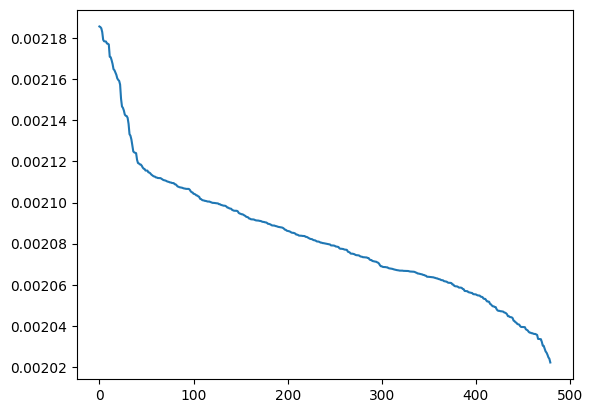

In [7]:
# plt.plot(cosine_sim.sort(descending=True)[0])
plt.plot(torch.softmax(cosine_sim.sort(descending=True)[0], 0))
plt.show()

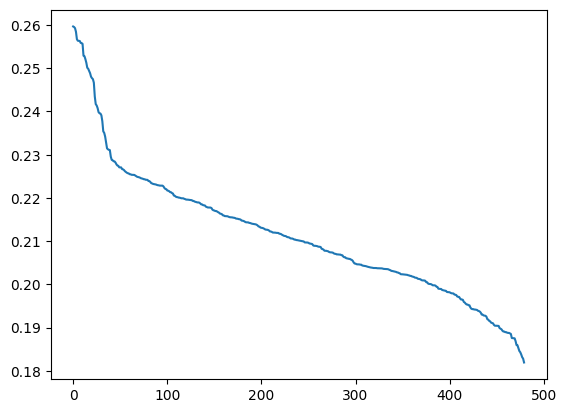

In [8]:
plt.plot(cosine_sim.sort(descending=True)[0])
# plt.plot(torch.softmax(cosine_sim.sort(descending=True)[0], 0))
plt.show()

In [23]:
torch.softmax(cosine_sim.sort(descending=True)[0], 0)

tensor([0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022,
        0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0021, 

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1783541/1708776835.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_info["distance"] = top5_distances[j].item()
/tmp/ipykernel_1783541/1708776835.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_info["distance"] = top5_distances[j].item()
/tmp/ipykernel_1783541/1708776835.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  color_info["distance"] = top5_distances

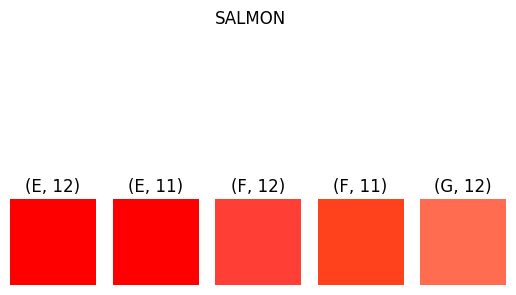

  0%|          | 0/100 [00:03<?, ?it/s]


In [6]:
results = defaultdict(list)
show_colors = True

# Iterate over all the words
it = 0
for word in tqdm(df_words.palabra.to_list()):

    text = tokenizer(word)

    # Get embeddings
    with torch.no_grad():
        text_embeds = model.encode_text(text)
        image_embeds = model.encode_image(color_images)

        # Normalize embeddings
        text_embeds /= text_embeds.norm(dim=-1, keepdim=True)
        image_embeds /= image_embeds.norm(dim=-1, keepdim=True)

        # Calculate cosine similarity
        cosine_sim = (text_embeds @ image_embeds.T).squeeze(0)

        # Get top 5 colors
        top5_indices = cosine_sim.argsort(descending=True)[:5]
        top5_distances = cosine_sim.sort(descending=True)[0][:5]

    # print(f"Top 5 colors for the word '{word}':")

    if show_colors: fig, axes = plt.subplots(1,5)
    for j, i in enumerate(top5_indices):
        color_info = df_colors.iloc[i.item()]
        color_info["distance"] = top5_distances[j].item()
        results[word].append(color_info.to_dict())
        # print(f"- Coords: ({color_info['coordenada_x']}, {color_info['coordenada_y']}), RGB: ({color_info['R']}, {color_info['G']}, {color_info['B']})")
        if show_colors:
            axes[j].imshow(color_images[i.item()].permute(1,2,0))
            axes[j].axis("off")
            axes[j].set_title(f"({color_info['coordenada_x']}, {color_info['coordenada_y']})")
    if show_colors:
        plt.suptitle(word)
        plt.show()
    break

In [ ]:
# Prepare the data to be stored in a CSV file
flat_data = [
    {**record, 'word':word} 
    for word, records in results.items() 
    for record in records
]

# Create the DataFrame
df = pd.DataFrame(flat_data)
cols = ['word'] + [c for c in df.columns if c != 'word']
df = df[cols]

df.to_csv("results_openclip.csv", index=0)
